In [1]:
!pip install python-dp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 10.2 MB/s eta 0:00:00


In [2]:
!unzip yellow_cab_data.zip

unzip:  cannot find or open yellow_cab_data.zip, yellow_cab_data.zip.zip or yellow_cab_data.zip.ZIP.


In [3]:
import pydp

In [68]:
import pandas as pd
df = pd.read_csv('yellow_cab_data.csv')

In [69]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

In [12]:
import numpy as np

In [37]:
import pandas as pd
from scipy.stats import entropy

def KL_Divergence(orig_df, df, column_name):

  # Calculate the KL divergence between the distributions of the two dataframes
  orig_df['frequency'] = pd.Series(pd.cut(orig_df[column_name].values, 1000))
  orig_f = orig_df['frequency'].value_counts(normalize=True).reset_index()['frequency'].values
  
  df['frequency'] = pd.Series(pd.cut(df[column_name].values, 1000))
  f = df['frequency'].value_counts(normalize=True).reset_index()['frequency'].values

  kl_divergence = entropy(orig_f, f)

  return kl_divergence

In [38]:
# Select the columns to be protected
sensitive_columns = ['trip_distance', 'fare_amount','tip_amount','extra']
updatedDf = df.copy()

#updatedDf =  pd.to_datetime(updatedDf['tpep_pickup_datetime']).timetuple()-
# Define the privacy budget (epsilon)
# Create a privacy mechanism using Laplace mechanism

curves = {}

# Apply the privacy mechanism to each sensitive column in the dataset
for col in sensitive_columns:
  curves[col] = []
  for epsilon in np.arange(0.1,1,0.05):
    laplace_mech = pydp.algorithms.numerical_mechanisms.LaplaceMechanism(epsilon=epsilon)
    updatedDf[col] = updatedDf[col].apply(lambda x: laplace_mech.add_noise(x))

    # TO add the total column
    score = KL_Divergence(df, updatedDf, col)
    curves[col].append((epsilon,score))




In [39]:
print(curves)

{'trip_distance': [(0.1, 0.3047917415582144), (0.15000000000000002, 0.31343501650256184), (0.20000000000000004, 0.22443490704498126), (0.25000000000000006, 0.3294766806331744), (0.30000000000000004, 0.1579872977080911), (0.3500000000000001, 0.11681300021100521), (0.40000000000000013, 0.1282223182924949), (0.45000000000000007, 0.11549401581474215), (0.5000000000000001, 0.12107688206521845), (0.5500000000000002, 0.11876888127970457), (0.6000000000000002, 0.12956314954812712), (0.6500000000000001, 0.14168875661542582), (0.7000000000000002, 0.17740356857431666), (0.7500000000000002, 0.1908447734513678), (0.8000000000000002, 0.20591028925305663), (0.8500000000000002, 0.23107776860572005), (0.9000000000000002, 0.21501096563652491), (0.9500000000000003, 0.1767348410179606)], 'fare_amount': [(0.1, 0.34156540010547204), (0.15000000000000002, 0.5068619182322092), (0.20000000000000004, 0.6061605944132529), (0.25000000000000006, 0.6601972356791856), (0.30000000000000004, 0.6972762374777582), (0.35

# Curve Plotting

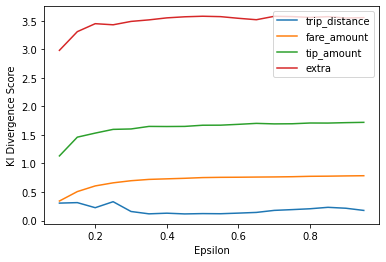

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.xlabel("Epsilon")
plt.ylabel("Kl Divergence Score")
for col in sensitive_columns:
  values = curves[col]
  epsilon = [x for x,y in values]
  scores = [y for x,y in values]
  plt.plot(epsilon,scores)
  
plt.show
plt.legend(sensitive_columns,loc ="upper right")

In [63]:
best_epsilon = {}
best_epsilon["trip_distance"] = 0.12
best_epsilon["fare_amount"] = 0.13
best_epsilon["tip_amount"] = 0.125
best_epsilon["extra"] = 0.225

In [64]:
finalDf = df.copy()
for col in sensitive_columns:
  laplace_mech = pydp.algorithms.numerical_mechanisms.LaplaceMechanism(epsilon=best_epsilon[col])
  finalDf[col] = finalDf[col].apply(lambda x: laplace_mech.add_noise(x))
  


## handling Categorical Variable

In [65]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle

correlated_and_categorical = ['tpep_pickup_datetime', 
               'tpep_dropoff_datetime', 
               'total_amount', 
               'store_and_fwd_flag', 
               'payment_type', 
               'RatecodeID', 'VendorID', 'frequency']

def get_categorical_attribute(df, clf, categorical):
  Xpred = df.drop(correlated_and_categorical, axis=1)
  Ytest = df[categorical]
  ypred = clf.predict(Xpred)
  acc = accuracy_score(Ytest, ypred)
  print("Accuracy:", acc)
  return ypred

finalDf = finalDf.dropna()
for colName in ["VendorID","store_and_fwd_flag"]:
  clf = pickle.load(open(colName + '.sav', 'rb'))
  finalDf[colName] = get_categorical_attribute(finalDf, clf, colName)

Accuracy: 0.6172221879096068
Accuracy: 0.7889842779596347


In [67]:
finalDf['RatecodeID'] = finalDf['RatecodeID'].apply(lambda x: hash(str(x)))
finalDf['payment_type'] = finalDf['payment_type'].apply(lambda x: hash(str(x)))

finalDf['PULocationID'] = finalDf['PULocationID'].apply(lambda x: hash(str(x)))
finalDf['DOLocationID'] = finalDf['DOLocationID'].apply(lambda x: hash(str(x)))

## Comparison

In [71]:
for col in sensitive_columns:
  print("Original Stats for Column:",col)
  print(df[col].describe())
  print("Transformed Stats for Column:",col)
  print(finalDf[col].describe())
  



Original Stats for Column: trip_distance
count    150000.000000
mean          6.176475
std         545.241861
min           0.000000
25%           1.040000
50%           1.740000
75%           3.140000
max      118618.940000
Name: trip_distance, dtype: float64
Transformed Stats for Column: trip_distance
count    145719.000000
mean          3.080450
std          12.583179
min         -83.844009
25%          -3.479760
50%           2.679008
75%           9.523670
max         245.925338
Name: trip_distance, dtype: float64
Original Stats for Column: fare_amount
count    150000.000000
mean         12.789388
std          12.411326
min        -230.000000
25%           6.500000
50%           9.000000
75%          14.000000
max         640.500000
Name: fare_amount, dtype: float64
Transformed Stats for Column: fare_amount
count    145719.000000
mean         12.607964
std          16.530874
min        -257.556151
25%           3.627512
50%          10.294933
75%          19.060624
max         643